In [1]:
import lxml
from absl import app, flags, logging
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from chars_detect import detect
from chars_model import CModel
from generate_dataset_plate import parse_xml
from plate_detect import detect_and_cut_single_img, cut_plate
from tools.dataset_utils import generate_xml
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
import yolov3_tf2.dataset_chars as dataset
import os
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import scipy.stats as st

def gkern(kernlen, N, sigma=None):
    """Returns a 2D Gaussian kernel."""
    if sigma is None:
        sigma = np.sqrt(kernlen/N)
    x = np.linspace(-sigma, sigma, kernlen)
    return st.norm.pdf(x)*2

In [288]:
image_root_path = './data/Plate_dataset/AC/train/jpeg/'
xml_in_root_path = './data/Plate_dataset/AC/train/xml/'

In [289]:
xmls = [filename for filename in os.listdir(xml_in_root_path) if filename.endswith('.xml')]

In [290]:
xml = '150.xml'
annotation_xml = lxml.etree.fromstring(open(os.path.join(xml_in_root_path, xml)).read())
annotation = parse_xml(annotation_xml)['annotation']
img_file_name = annotation['filename']
img_path = os.path.join(image_root_path, img_file_name)
xmin = int(annotation['object'][0]['bndbox']['xmin'])
ymin = int(annotation['object'][0]['bndbox']['ymin'])
xmax = int(annotation['object'][0]['bndbox']['xmax'])
ymax = int(annotation['object'][0]['bndbox']['ymax'])

In [291]:
border_delta=10

In [292]:
def bw_process(img, gk_size, bias, gau):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    #equ = cv2.equalizeHist(img_grey)
    #equ = cv2.normalize(img_grey, normType=cv2.NORM_MINMAX)
    equ = img_grey - np.min(img_grey)
    equ = equ.astype(np.float) / np.max(equ) * 255.0
    equ = equ.astype(np.uint8)
    equ = cv2.medianBlur(equ, 3)
    if gau:
        img_bw = cv2.adaptiveThreshold(equ, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, gk_size, bias)
        img_bw = 255 - img_bw
    else:
        _, img_bw = cv2.threshold(equ,127,255,cv2.THRESH_BINARY_INV)
    return img_bw

In [293]:
img_raw = img_rawer = tf.image.decode_jpeg(open(img_path, 'rb').read())
img_rawer = cut_plate(img_rawer, xmin, ymin, xmax, ymax)

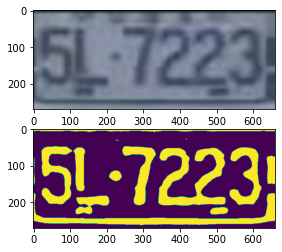

In [296]:
img_raw = cv2.GaussianBlur(img_rawer, (15,15),0)
img_bw = bw_process(img_raw, gk_size=75, bias=16, gau=True)
plt.subplot(2,1,1).imshow(img_raw)
plt.subplot(2,1,2).imshow(img_bw)

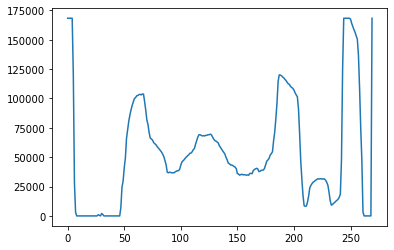

In [297]:
sum_column = np.sum(img_bw, axis=1).astype(np.int32)
mx = np.max(sum_column)
sum_column[0] = mx + 1
sum_column[-1] = mx + 1
plt.plot(sum_column)

In [298]:
step = sum_column.max() / 200
thresh = sum_column.max()/7 - step
bogus = []
#tot = 0
while len(bogus) < 2:
    #tot += 1
    #if tot > 20:
    #    break
    thresh += step
    bogus = signal.find_peaks(-sum_column, distance=10, height=-thresh)[0]
    #print(bogus, thresh)
    if len(bogus) >= 2:
        if np.diff(bogus).max() / img_raw.shape[0] < 0.4:
            bogus = []
bogus

array([ 17,  29,  39, 210, 233, 265])

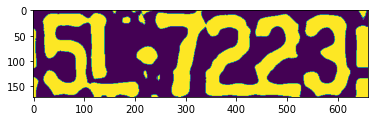

In [299]:
bogus_diff = np.diff(bogus)
pos = np.argmax(bogus_diff)
L,R = bogus[pos],bogus[pos+1]
row_cuted = img_raw[L:R]
img_bw = bw_process(row_cuted, gk_size=67, bias=2, gau=True)
plt.imshow(img_bw)

In [300]:
row_cuted_blured = cv2.medianBlur(img_bw, 3)
contours, hierarchy = cv2.findContours(row_cuted_blured, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(row_cuted_blured.shape[:2], dtype=row_cuted_blured.dtype)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if h < row_cuted_blured.shape[0] * 0.5 or w < row_cuted_blured.shape[1] * 0.05:
        cv2.drawContours(row_cuted_blured, [cnt], -1, color=0, thickness=cv2.FILLED)

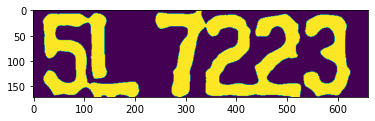

In [301]:
plt.imshow(row_cuted_blured)

In [302]:
char_width = (row_cuted_blured.shape[1]-border_delta*2) // 6

255


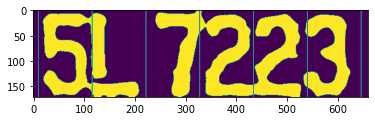

In [303]:
tmp = row_cuted_blured.copy()
print(tmp.max())
for i in range(7):
    tmp[:,char_width*i+border_delta]=255-tmp[:,char_width*i+border_delta]
plt.imshow(tmp)

In [304]:
sum_col = np.sum(row_cuted_blured, axis=0)

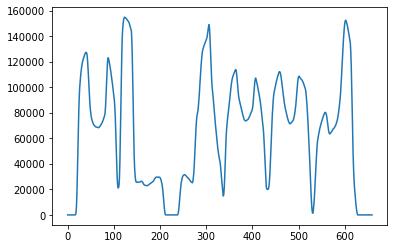

In [305]:
kern_size = max(int(char_width*0.06), 6)
#if kern_size % 2 == 0:
#    kern_size += 1
sum_col_smooth = np.convolve(sum_col, gkern(kern_size, N=kern_size), mode='same')
plt.plot(sum_col_smooth)

In [306]:
def find_minimum(arr, s, d):
    L = max(0,s-d)
    R = min(arr.shape[0], s+d+1)
    return np.argmin(arr[L:R]) + L

In [307]:
find_minimum(sum_col_smooth, char_width, int(char_width*0.2))

109

In [308]:
lst = [find_minimum(sum_col, char_width * i+border_delta, int(char_width*0.2)) for i in range(7)]

In [309]:
lst

[0, 108, 209, 339, 430, 528, 625]

In [326]:
def find_border(arr, L, R):
    while arr[L] == 0:
        L += 1
    while arr[R] == 0:
        R -= 1
    return L, R

def remove_noise(img, delta = 5):
    img_backup = img.copy()
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h < img.shape[0] * 0.3 or w < img.shape[1] * 0.1 \
                or x > img.shape[0] / 2 + delta or x + w < img.shape[0] / 2 - delta \
                or y > img.shape[1] / 2 + delta or y + h < img.shape[1] / 2 - delta:
            cv2.drawContours(img, [cnt], -1, color=0, thickness=cv2.FILLED)

    try:
        U, D = find_border(np.sum(img, axis=1), 0, img.shape[0] - 1)
        L, R = find_border(np.sum(img, axis=0), 0, img.shape[1] - 1)
    except Exception:
        img = img_backup
        U, D = find_border(np.sum(img, axis=1), 0, img.shape[0] - 1)
        L, R = find_border(np.sum(img, axis=0), 0, img.shape[1] - 1)
    return img[U:D, L:R]

In [327]:
chrs = [remove_noise(row_cuted_blured[:,L:R].copy()) for L,R in zip(lst[:-1], lst[1:])]

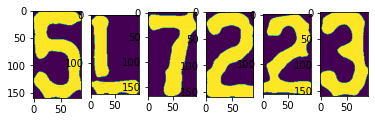

In [328]:
N=len(chrs)
for i in range(N):
    plt.subplot(1,N,i+1).imshow(chrs[i])